Lecture: AI I - Advanced 

Previous:
[**Chapter 1.1: Neuron**](../01_basics/01_neuron.ipynb)

---

# Chapter 1.2: Multi Layer Perceptron

- [Architecture](#architecture)
- [Gradient Descent: The Optimization Algorithm](#gradient-descent-the-optimization-algorithm)
- [Backpropagation: Efficient Gradient Computation](#backpropagation-efficient-gradient-computation)
- [Complete Training Example: Regression with Full Pipeline](#complete-training-example-regression-with-full-pipeline)

Now that we understand individual neurons and activation functions, we're ready to combine them into something far more powerful: Multi-Layer Perceptrons (MLPs). A single neuron, no matter how sophisticated its activation function, can only learn linear decision boundaries (or simple non-linear transformations). But when we stack neurons into layers and connect them together, something remarkable happens — the network gains the ability to learn arbitrarily complex functions.

In this section, we'll explore:
* How to architect networks with multiple layers
* How to measure prediction quality with **loss functions**
* How to optimize these networks using **gradient descent**
* How **backpropagation** computes gradients efficiently through deep networks

This is where the pieces come together to form a complete, trainable neural network.

## Architecture

A **Multi-Layer Perceptron** consists of:
1. **Input Layer**: Raw features (not trainable, just passes data forward)
2. **Hidden Layer(s)**: One or more layers of neurons that learn representations
3. **Output Layer**: Produces final predictions (e.g., class probabilities, regression outputs)

**Key Insight**: Each layer transforms the data into a new representation. Early layers learn simple features, deeper layers learn increasingly abstract concepts.

In [1]:
import torch.nn as nn
import torch.nn.functional as F

class RegressionMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

## Loss Functions: Measuring Prediction Quality

A **loss function** (or **cost function**) quantifies how wrong our predictions are. The goal of training is to **minimize this loss**.

Properties of Good Loss Functions
1. **Always non-negative**: $\mathcal{L} \geq 0$
2. **Zero at perfect prediction**: $\mathcal{L} = 0$ when $\hat{y} = y$
3. **Differentiable**: We need gradients for backpropagation
4. **Convex (ideally)**: Makes optimization easier
---
### 1. Mean Squared Error (MSE) – For Regression

**Use case**: Predicting continuous values (house prices, temperature, etc.)

**Mathematical Definition:** $\mathcal{L}_{\text{MSE}} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

**Intuition**: Penalizes predictions quadratically—large errors are punished heavily.

---
### 2. Binary Cross-Entropy (BCE) – For Binary Classification

**Use case**: Two-class problems (spam/not spam, disease/healthy)

**Mathematical Definition:** $\mathcal{L}_{\text{BCE}} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$

Where:
- $y_i \in \{0, 1\}$ (true labels)
- $\hat{y}_i \in (0, 1)$ (predicted probabilities from sigmoid)

**Intuition**: Heavily penalizes confident wrong predictions.

---
### 3. Cross-Entropy Loss – For Multi-Class Classification

**Use case**: Multiple mutually exclusive classes (digit recognition, image classification)

**Mathematical Definition:** $\mathcal{L}_{\text{CE}} = -\frac{1}{n} \sum_{i=1}^{n} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})$

Where:
- $y_{i,c}$ = 1 if sample $i$ is class $c$, else 0 (one-hot encoded)
- $\hat{y}_{i,c}$ = predicted probability for class $c$ (from softmax)
- $C$ = number of classes

**Simplified form** when $y$ is class index (not one-hot): 
$$\mathcal{L}_{\text{CE}} = -\log(\hat{y}_{\text{true class}})$$

### Loss Function Comparison

| Loss Function | Use Case | Output Layer | Target Format | PyTorch |
|----------------|----------|--------------|---------------|---------|
| Mean Squared Error (MSE) | Regression | Linear (no activation) | Continuous values | `nn.MSELoss()` |
| Binary Cross-Entropy (BCE) | Binary Classification | Sigmoid | Binary labels (0/1) | `nn.BCELoss()` |
| Cross-Entropy Loss | Multi-Class Classification | No activation (logits) | One-hot or class indices | | `nn.CrossEntropyLoss()` |

In [2]:
import torch

criterion = nn.MSELoss()

predictions = torch.tensor([250.0, 320.0, 180.0, 290.0])
targets = torch.tensor([260.0, 310.0, 190.0, 285.0]) 

loss = criterion(predictions, targets)
print(f"MSE Loss: {loss.item():.4f}")

MSE Loss: 81.2500


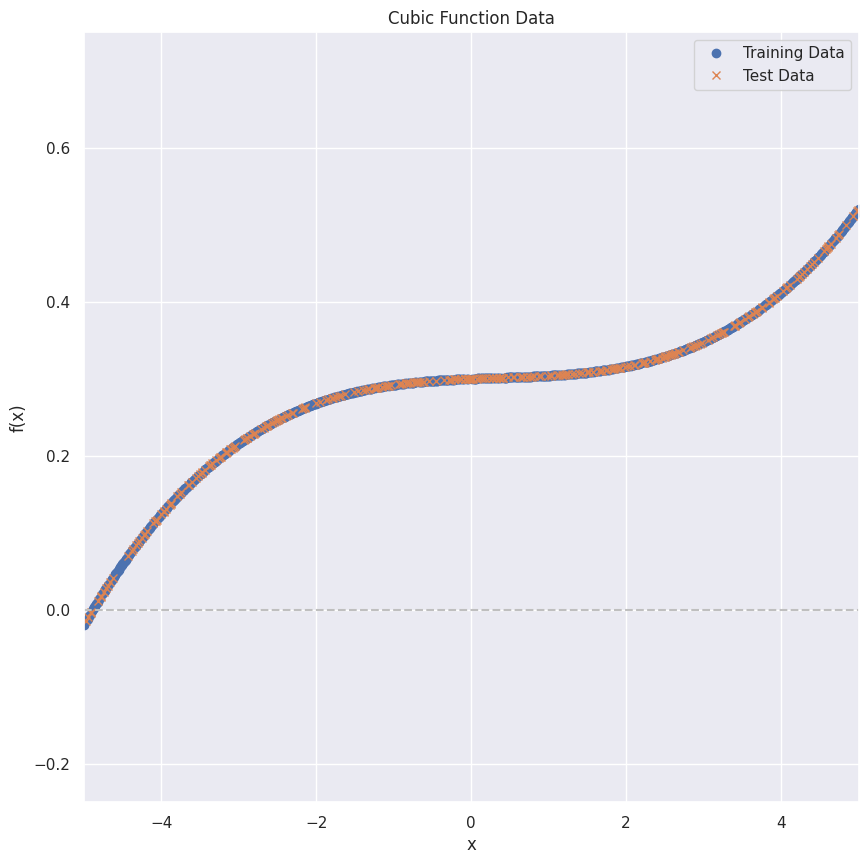

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def f(x):
    return 0.002*(x**3-x**2+2*x)+0.3

n = 1_000
x = torch.linspace(-5,5, n).reshape(-1, 1)
y = f(x)

ids = torch.arange(len(x))
train_ids = torch.randperm(len(x))[:700]
test_ids = ~torch.isin(ids, train_ids)
x_train = x[train_ids]
y_train = y[train_ids]
x_test = x[test_ids]
y_test = y[test_ids]


sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_train, y_train, 'o', label='Training Data')
ax.plot(x_test, y_test, 'x', label='Test Data')
ax.axhline(0, color="0.75", linestyle="--")
ax.set(ylabel='f(x)', xlabel='x', title="Cubic Function Data", xlim=(-5, 5), ylim=(-0.25, 0.75))
ax.legend()

In [4]:
model = RegressionMLP(input_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(50):
    # Forward pass
    predictions = model(x_train)
    loss = criterion(predictions, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.0470
Epoch 20, Loss: 0.0357
Epoch 30, Loss: 0.0277
Epoch 40, Loss: 0.0214
Epoch 50, Loss: 0.0166


## Gradient Descent: The Optimization Algorithm

Imagine you're standing on a mountainside in thick fog, and you want to reach the valley (the minimum point). You can't see where the valley is, but you can feel the slope beneath your feet. **Gradient descent** is exactly this strategy: repeatedly take small steps in the direction where the ground slopes downward most steeply. Eventually, you'll reach a low point.

In neural networks, the "mountain" is your **loss landscape** - a high-dimensional surface where each position represents a different set of weights, and the height at that position is the loss (error). Your goal is to find the weights that give you the lowest loss.

The **gradient** is like a compass that points uphill. Since we want to go downhill, we move in the **opposite direction** of the gradient. The **learning rate** determines how big each step is—too small and you'll take forever to reach the bottom; too large and you might overshoot or even bounce around chaotically.

### How It Works: The Update Process

At each step, the algorithm does three things:
1. **Evaluate where you are**: Calculate the loss with your current weights
2. **Feel the slope**: Compute the gradient (which direction is uphill?)
3. **Take a step downhill**: Adjust the weights by moving opposite to the gradient

This process repeats hundreds or thousands of times until the loss stops decreasing significantly, meaning you've found a good minimum (hopefully!).

### Three Flavors of Gradient Descent
**Batch Gradient Descent** is like being very careful—you look at your entire dataset before taking each step. This gives you the most accurate direction, but it's slow when you have millions of data points. It's like consulting every single person in a city before making a decision.

**Stochastic Gradient Descent (SGD)** is the opposite extreme—you look at just one random example and immediately take a step based on that. This is much faster, but your steps are noisy and erratic because each individual example might be misleading. However, this noise can actually be helpful—it can shake you out of bad local minima that batch gradient descent might get stuck in.

**Mini-Batch Gradient Descent** is the Goldilocks compromise—you look at a small random group of examples (typically 32, 64, or 128) before each step. This balances the stability of batch gradient descent with the speed of SGD, and it's what everyone uses in practice. It's also perfectly suited for GPUs, which excel at processing batches of data in parallel.

### The Learning Rate: Your Most Important Knob

The learning rate is arguably the most critical hyperparameter. Think of it as the size of your steps down the mountain:
- **Too small**: You'll take tiny steps and might need days to reach the valley. Training is painfully slow.
- **Just right**: You make steady progress, converging smoothly to a good solution.
- **Too large**: You take such big steps that you leap over the valley entirely, possibly ending up higher than you started. The loss might even explode to infinity!

A common strategy is to start with a moderate learning rate and gradually reduce it as training progresses—like switching from running to walking as you get close to your destination.

## Backpropagation: Efficient Gradient Computation

Neural networks have millions of parameters, and we need the gradient for **every single one** to perform gradient descent. Computing these individually would be impossibly slow. **Backpropagation** solves this by computing all gradients in a single backward sweep through the network, cleverly reusing calculations via the chain rule from calculus.

### How It Works

**Forward Pass**: Data flows through the network (input → hidden layers → output → loss) while we save all intermediate values. These are our "breadcrumbs" for the return journey.

**Backward Pass**: Starting from the loss, we work backward layer by layer, asking: "How much did each weight contribute to the error?" The chain rule lets us trace effects systematically—the gradient of a weight in layer 1 depends on all subsequent layers, and we compute this by multiplying gradients as we go backward.

## Complete Training Example: Regression with Full Pipeline

In [5]:
from datetime import datetime

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f'./data/02_mlp/runs/run_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

x_norm = (x - x.mean(dim=0, keepdim=True)) / x.std(dim=0, keepdim=True)
ids = torch.randperm(len(x))
train_ids = ids[:int(n * .6)]
val_ids = ids[int(n * .6):int(n * .8)]
test_ids = ids[int(n * .8):]

train_dataset = TensorDataset(x_norm[train_ids], y[train_ids])
val_dataset = TensorDataset(x_norm[val_ids], y[val_ids])
test_dataset = TensorDataset(x_norm[test_ids], y[test_ids])

batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True  # Shuffle training data each epoch
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False  # Don't shuffle validation
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False  # Don't shuffle test
)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 19
Validation batches: 7
Test batches: 7


In [6]:
model = RegressionMLP(input_dim=1)

# Log the model architecture to TensorBoard
writer.add_graph(model, x_norm[train_ids][:batch_size])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Architecture:
RegressionMLP(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 2,241
Trainable parameters: 2,241


In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Reduce LR when validation loss stops decreasing
    factor=0.5,      # Multiply LR by 0.5
    patience=10,     # Wait 10 epochs before reducing
)

def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()  # Set model to training mode
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
    
    return train_loss / len(train_loader.dataset)  # Return average loss

def validate(model, val_loader, criterion):
    """Validate the model"""
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    return val_loss / len(val_loader.dataset)

def compute_metrics(model, data_loader):
    """Compute detailed regression metrics"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            predictions = model(batch_X)
            all_predictions.append(predictions)
            all_targets.append(batch_y)
    
    predictions = torch.cat(all_predictions, dim=0)
    targets = torch.cat(all_targets, dim=0)
    
    mse = F.mse_loss(predictions, targets).item()        
    return {
        'mse': mse,                                     # Mean Squared Error (MSE)
        'rmse': np.sqrt(mse),                           # Root Mean Squared Error (RMSE)
        'mae': F.l1_loss(predictions, targets).item(),  # Mean Absolute Error (MAE)
    }

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 20

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, val_loader, criterion)
    val_losses.append(val_loss)

    # Log losses to TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalars('Loss/Train_vs_Val', {'Train': train_loss, 'Validation': val_loss}, epoch)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        torch.save(model.state_dict(), './data/02_mlp/model.pth')  # Save best model
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:7.4f} | "
              f"Val Loss: {val_loss:7.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

writer.close()

Epoch   1/100 | Train Loss:  0.0152 | Val Loss:  0.0059 | LR: 0.001000
Epoch  10/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000
Epoch  20/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000
Epoch  30/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000
Epoch  40/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000
Epoch  50/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000
Epoch  60/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000
Epoch  70/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000
Epoch  80/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000
Epoch  90/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000
Epoch 100/100 | Train Loss:  0.0000 | Val Loss:  0.0000 | LR: 0.001000


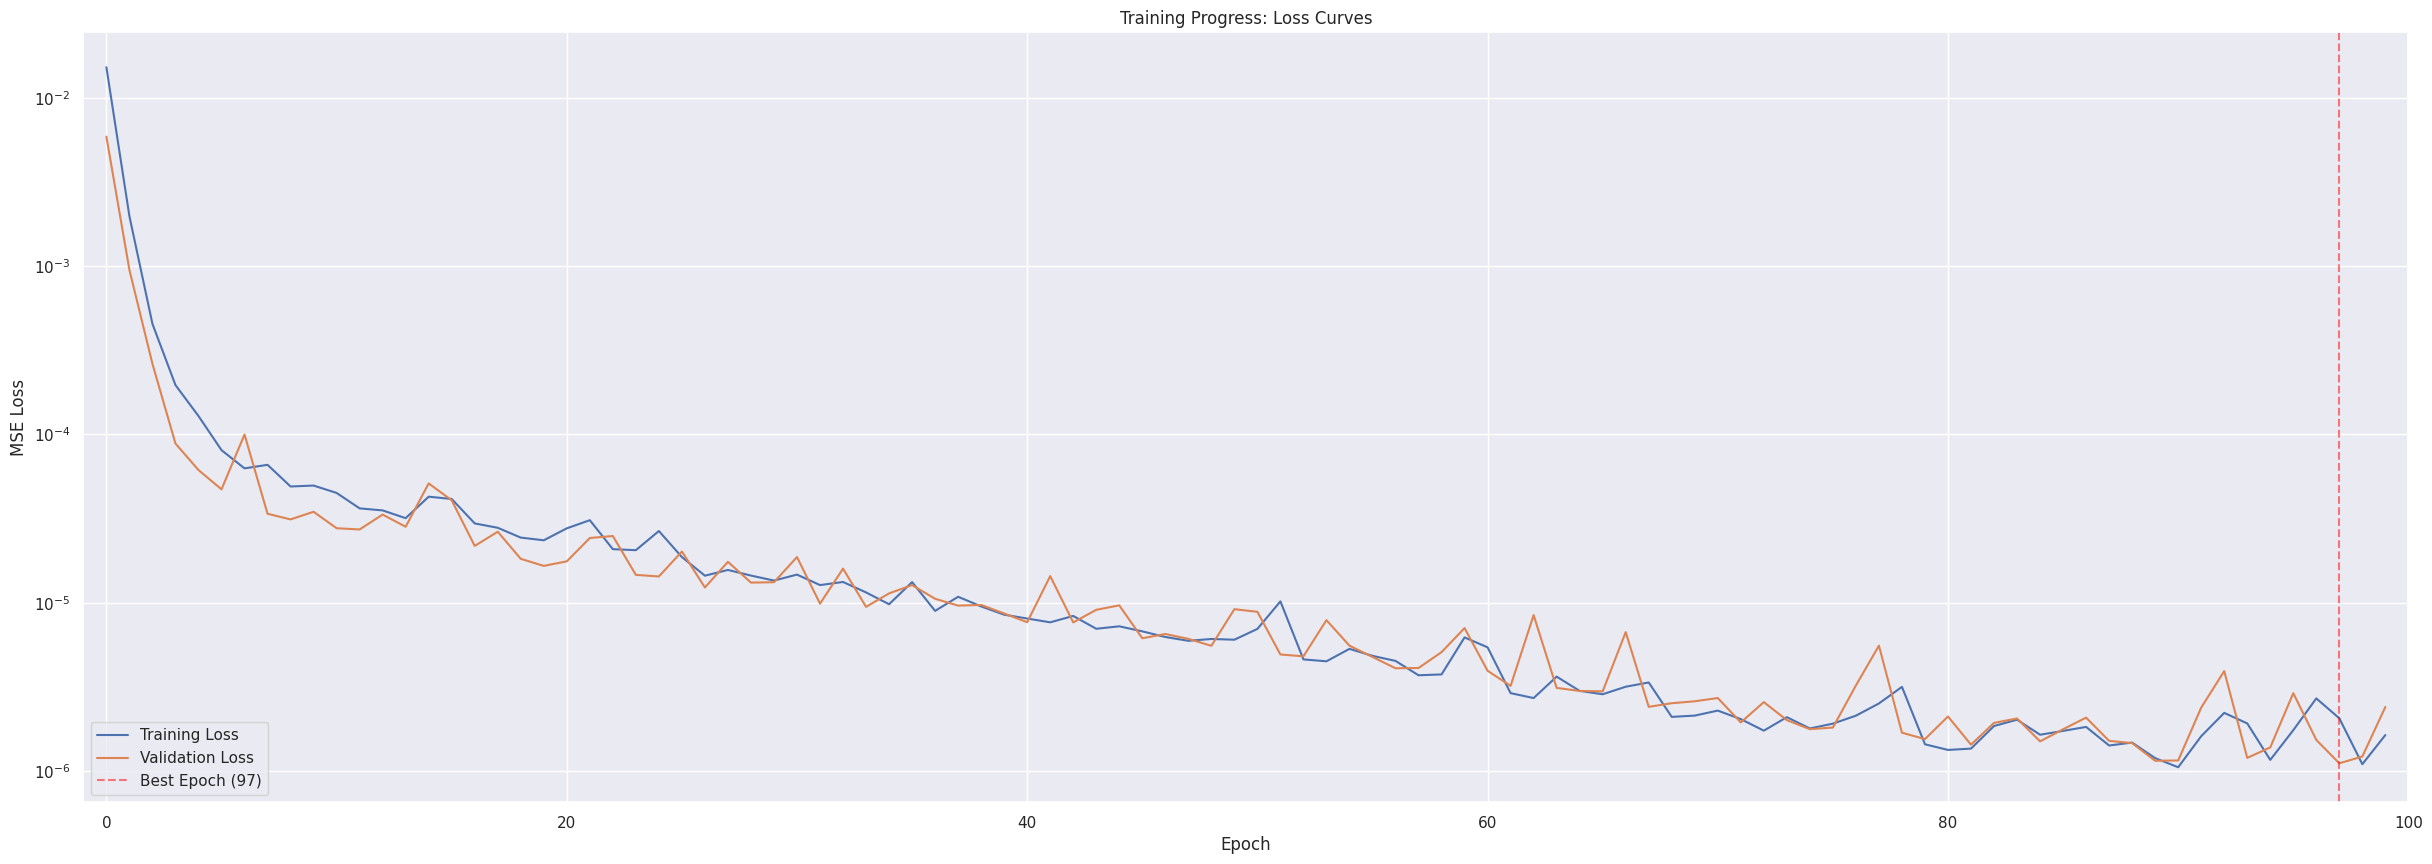

In [8]:
import numpy as np

fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set(xlabel='Epoch', ylabel='MSE Loss', title='Training Progress: Loss Curves', yscale='log', xlim=(-1, len(train_losses)))

# Mark best epoch
best_epoch = np.argmin(val_losses)
ax.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')

ax.legend()

In [9]:
model.load_state_dict(torch.load('./data/02_mlp/model.pth'))

train_metrics = compute_metrics(model, train_loader)
val_metrics = compute_metrics(model, val_loader)
test_metrics = compute_metrics(model, test_loader)  # Compute test metrics
print(f"MSE:  {test_metrics['mse']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f} (± ${test_metrics['rmse']:.2f}k average error)")
print(f"MAE:  {test_metrics['mae']:.4f} (${test_metrics['mae']:.2f}k average error)")

MSE:  0.0000
RMSE: 0.0011 (± $0.00k average error)
MAE:  0.0007 ($0.00k average error)


In [10]:
y[test_ids].flatten().shape, model(x_norm[test_ids]).flatten().shape

(torch.Size([200]), torch.Size([200]))

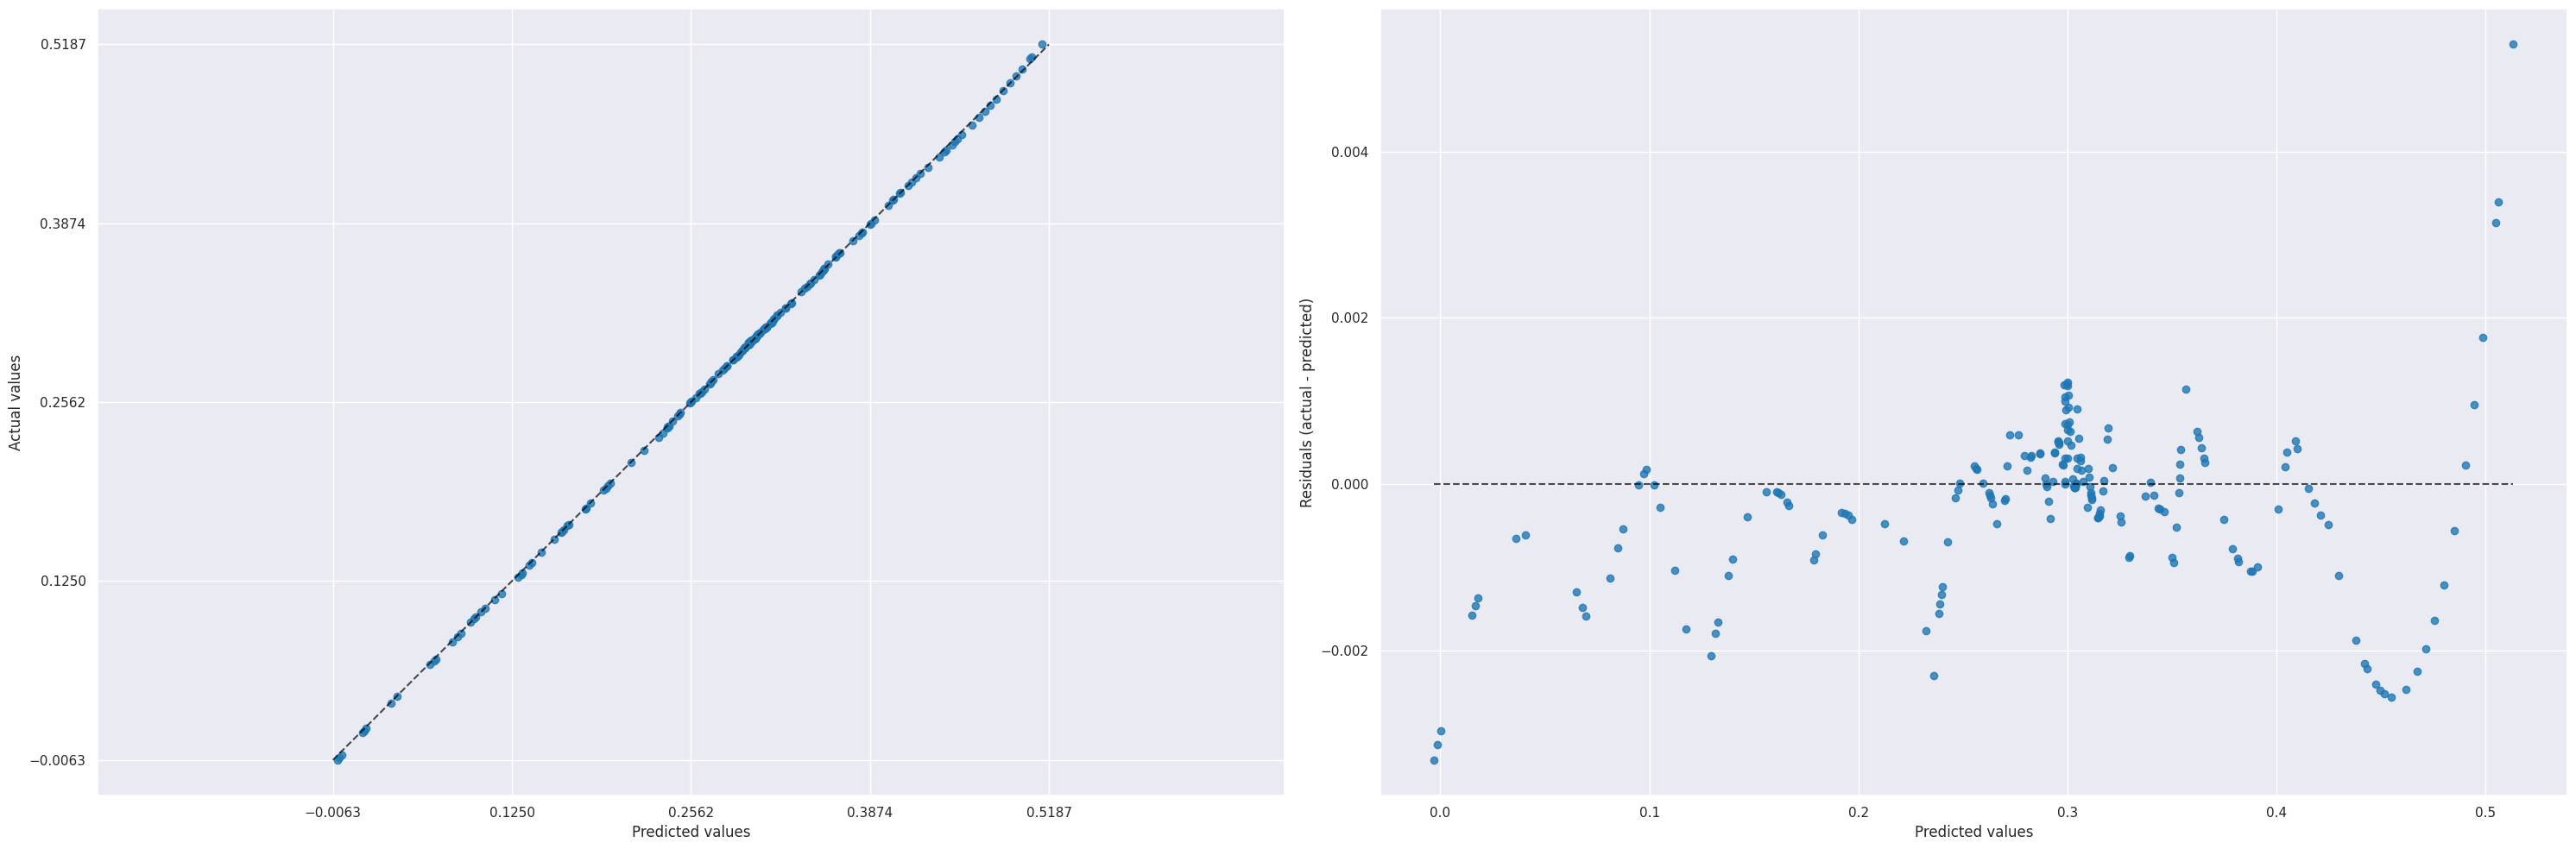

In [11]:
from sklearn.metrics import PredictionErrorDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

y_true = y[test_ids].numpy()
y_pred = model(x_norm[test_ids]).detach().numpy()

PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    ax=ax1,
    kind='actual_vs_predicted',
)
PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    kind='residual_vs_predicted',
    ax=ax2,
)
fig.tight_layout()

### Tensorboard

[TensorBoard](https://docs.pytorch.org/docs/main/tensorboard.html) is PyTorch's built-in visualization toolkit that transforms your training process from a stream of numbers into interactive, real-time visualizations. Instead of watching loss values scroll in your terminal, you get beautiful plots of training curves, model graphs, weight distributions, and more—all accessible through a web browser. The beauty of TensorBoard is its simplicity: add a `SummaryWriter` to your code, log metrics with writer.add_scalar('loss', loss, epoch), launch the interface with `tensorboard --logdir=runs`, and you're done. It's invaluable for debugging (spot vanishing gradients instantly), comparing experiments (which learning rate works best?), and understanding what your network is actually doing during training.

In [12]:
%load_ext tensorboard
%tensorboard --host 0.0.0.0 --port=8080  --logdir=./data/02_mlp/runs 

---

Lecture: AI I - Advanced 

Exercise: [**Exercise 1.2: Multilayer Perceptron**](../01_basics//exercises/02_mlp.ipynb)

Next: [**Chapter 2.1: Regularization**](../02_training/01_regularization.ipynb)